## Analysing 666k tweets about India's most-awaited legal verdict

In [90]:
# Change the backend to enable loading of emoji font
import matplotlib, mplcairo
print('Default backend: ' + matplotlib.get_backend()) 
matplotlib.use("module://mplcairo.macosx")
print('Backend is now ' + matplotlib.get_backend())

Default backend: module://ipykernel.pylab.backend_inline
Backend is now module://mplcairo.macosx


In [91]:
# Import required libraries
import pandas as pd
import numpy as np
import re 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.tokenize import regexp_tokenize
from collections import Counter
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import #AyodhyaVerdict tweets dataset (downloaded in R)
tweets = pd.read_csv("verdict_tweets_ist.csv", low_memory = False)

In [4]:
# Count number of tweets and tweet attributes
tweets.shape

(666323, 90)

In [92]:
# Group languages other than English and Hindi as Other
langs = ["en", "hi"]
tweets.loc[~tweets.lang.isin(langs), 'lang'] = "other"

In [93]:
# Create new datasets for analysis
tweets_original = tweets[tweets["is_retweet"] == False]
tweets_english = tweets[tweets["lang"] == "en"]
tweets_original_eng = tweets_english[tweets_english["is_retweet"] == False]
tweets_hindi = tweets[tweets["lang"] == "hi"]
tweets_original_hi = tweets_hindi[tweets_hindi["is_retweet"] == False]
verified = tweets[tweets["verified"] == True]
not_verified = tweets[tweets["verified"] == False] 

In [7]:
# Count number of original tweets
len(tweets_original)

118711

In [8]:
# Calculate percentage of English tweets
len(tweets_english) / len(tweets) * 100

56.098318683281235

In [9]:
# Calculate percentage of Hindi tweets
len(tweets_hindi) / len(tweets) * 100

32.92697385502226

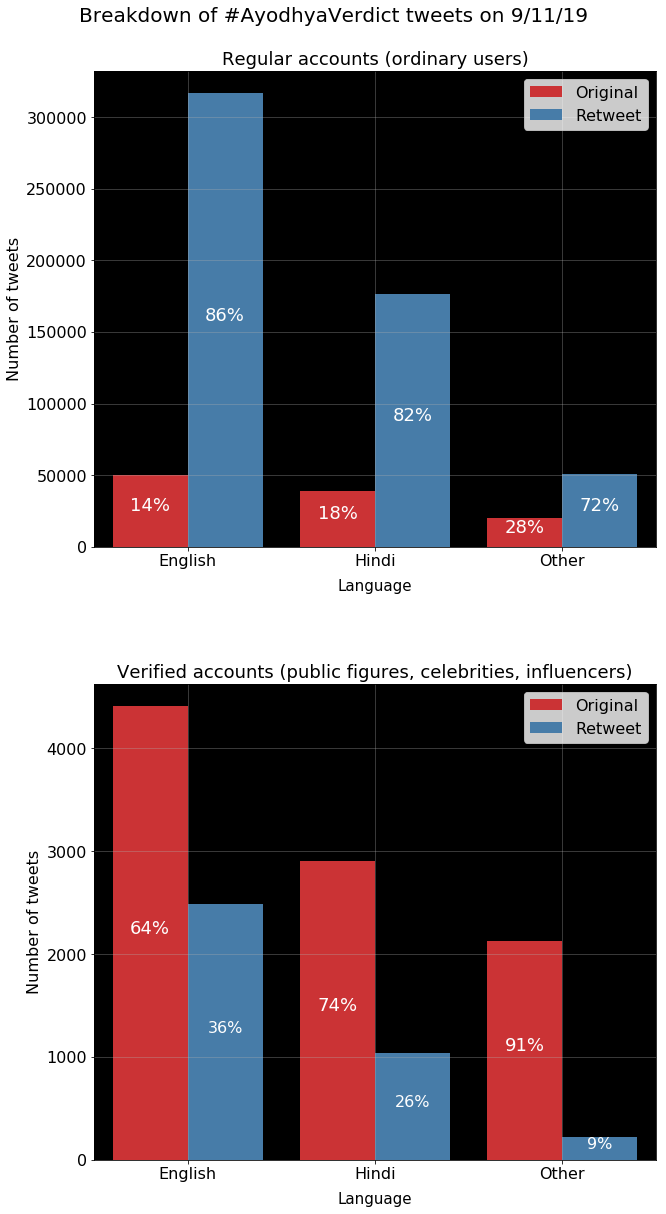

In [94]:
# Plot and compare breakdown of all tweets by language, tweet type and user type
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (11, 18))
fig.suptitle("Breakdown of #AyodhyaVerdict tweets on 9/11/19", fontsize = 20)
a = sns.countplot(not_verified["lang"], hue = not_verified["is_retweet"], order = not_verified["lang"].value_counts().index, 
                  palette = "Set1", ax = ax[0])
a.axes.set_title("Regular accounts (ordinary users)", fontsize = 18)
a.tick_params(labelsize = 16)
a.axes.set_xticklabels(["English", "Hindi", "Other"])
a.set_ylabel("Number of tweets", fontsize = 16)
a.set_xlabel("Language", fontsize = 15, labelpad = 10)
a.axes.legend(["Original", "Retweet"], fontsize = 16)
a.set_facecolor('xkcd:black')
a.grid(alpha = 0.4)

bars = a.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    a.text(left.get_x() + left.get_width()/2., height_l /2, '{0:.0%}'.format(height_l/total), ha="center", 
           color = 'white', fontsize = 18)
    a.text(right.get_x() + right.get_width()/2., height_r /2, '{0:.0%}'.format(height_r/total), ha="center", 
           color = 'white', fontsize = 18)
        
b = sns.countplot(verified["lang"], hue = verified["is_retweet"], order = verified["lang"].value_counts().index, 
                  palette = "Set1", ax = ax[1])
b.axes.set_title("Verified accounts (public figures, celebrities, influencers)", fontsize = 18)
b.tick_params(labelsize = 16)
b.axes.set_xticklabels(["English", "Hindi", "Other"])
b.set_ylabel("Number of tweets", fontsize = 16)
b.set_xlabel("Language", fontsize = 15, labelpad = 10)
b.axes.legend(["Original", "Retweet"], fontsize = 16)
b.set_facecolor('xkcd:black')
b.grid(alpha = 0.4)

bars = b.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]
for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    b.text(left.get_x() + left.get_width()/2., height_l /2, '{0:.0%}'.format(height_l/total), ha="center", 
           color = 'white', fontsize = 18)
    b.text(right.get_x() + right.get_width()/2., height_r /2, '{0:.0%}'.format(height_r/total), ha="center", 
           color = 'white', fontsize = 16)
    
plt.tight_layout(pad = 7)
fig.show()


We will define a function for preprocessing the tweets and performing VADER sentiment analysis on them. We will want to exclude topic descriptors from the text, which we will do via regex substitution instead of stopword removal. This is because stopword removal requires word tokenization, which would interfere with our sentence-level sentiment analysis.

In [95]:
# Define a function for sentiment analysis and classification

def get_sentiment(tweet):

    # Remove @usernames, URLs and hashtag symbols
    clean_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|(#)", " ", tweet).split()) 
    # Replace topic descriptors with blank spaces
    lean_tweet = re.sub("ayodhya|Ayodhya|Verdict|AyodhyaVerdict|AYODHYAVERDICT|AYODHYA|VERDICT|Supreme|Court|Sunni|Waqf|Board|sunni|waqf|Ram|temple|court|mosque|judgment|judgement|verdict|dispute|amp|SC|today|alternate|land|Case|Hearing|Judgment|Judgement|case|acre|Mandir|BabriMasjid|Babri|Masjid|build|Muslim|Islamic|structure|Justice", " ", clean_tweet)
    # Calculate sentiment
    score = analyser.polarity_scores(lean_tweet)
    lb = score['compound']

    if lb >= 0.05:
        return "positive"
    elif (lb > -0.05) and (lb < 0.05):
        return "neutral"
    else:
        return "negative"

In [96]:
s = 'this is a test'

In [97]:
get_sentiment(s)

'neutral'

In [116]:
%%time
# Get tweet sentiments 
tweets_english["sentiment"] = tweets_english["text"].apply(get_sentiment)
tweets_original_eng["sentiment"] = tweets_original_eng["text"].apply(get_sentiment)

CPU times: user 3min 18s, sys: 944 ms, total: 3min 19s
Wall time: 3min 20s


In [117]:
# Reorder factor levels for plotting
tweets_original_eng["sentiment"] = tweets_original_eng["sentiment"].astype("category")
tweets_original_eng["sentiment"].cat.reorder_categories(['positive', 'neutral', 'negative'], inplace = True)

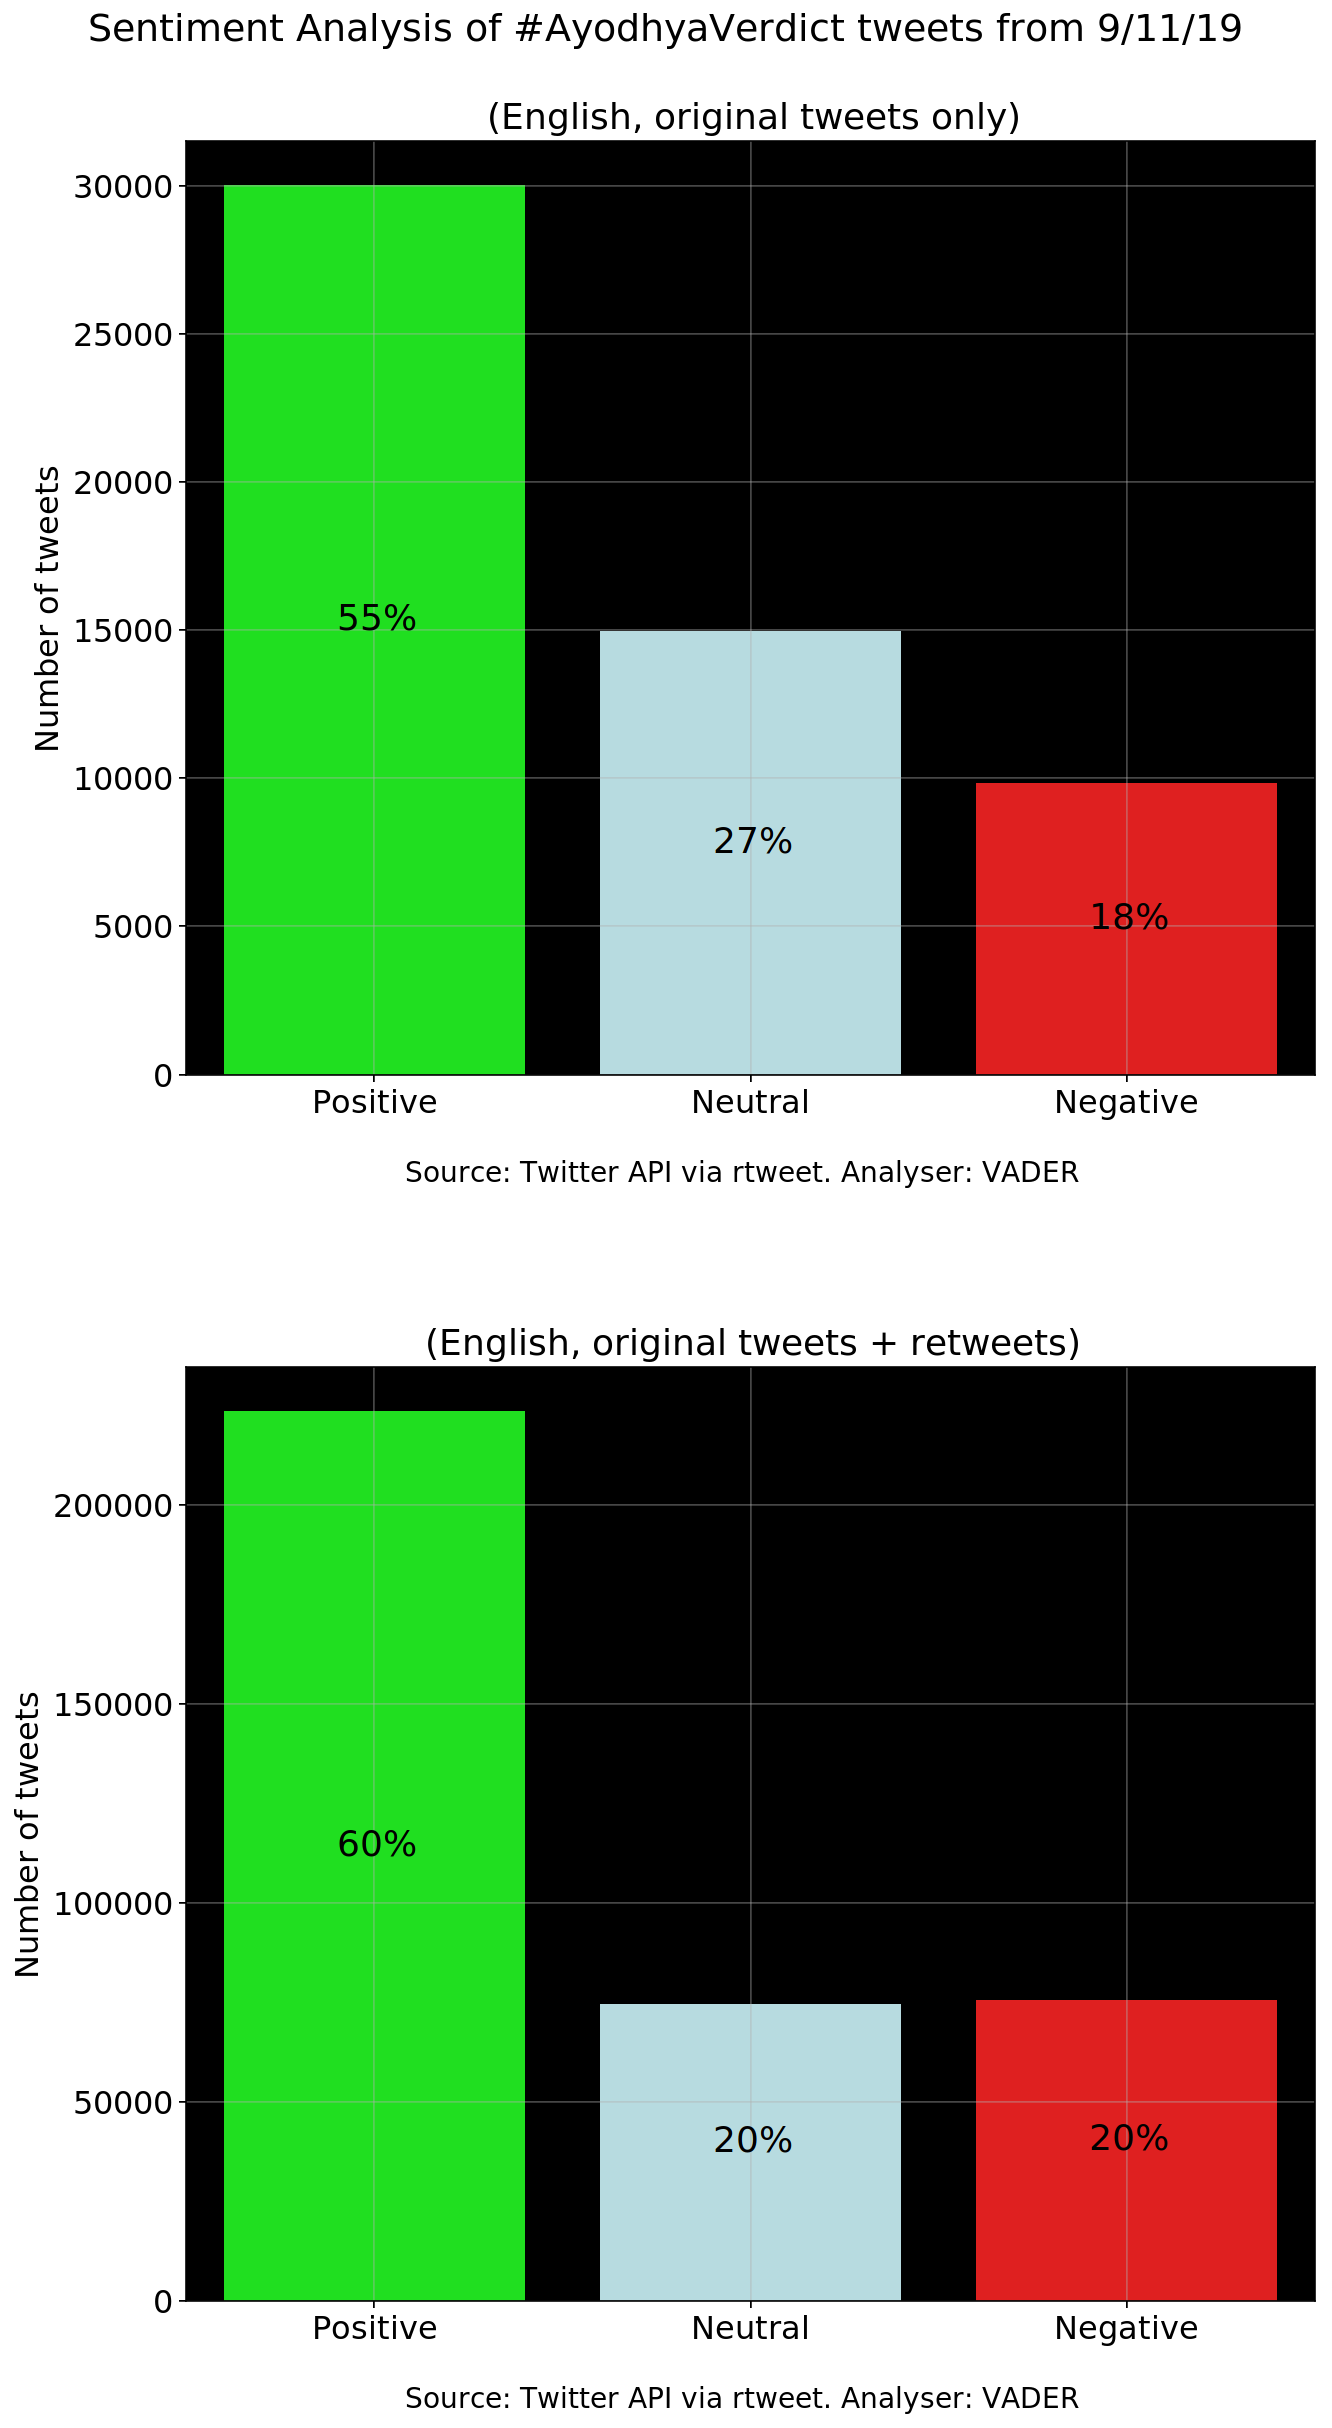

In [131]:
# Plot and compare sentiment analysis of original tweets and original + retweets datasets

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (11, 18))
fig.suptitle("Sentiment Analysis of #AyodhyaVerdict tweets from 9/11/19", fontsize = 19)
a = sns.countplot(x = 'sentiment', data = tweets_original_eng,
                      palette = ["lime", "powderblue", "red"], ax = ax[0])
totals = []
for i in a.patches:
    totals.append(i.get_height())
total = sum(totals)

for i in a.patches:
    a.text(x = i.get_x()+0.3, y = i.get_y()+ (i.get_height()/2), s = '{0:.0%}'.format(i.get_height()/total), 
                fontsize=18, color='black')
    
a.axes.set_title("(English, original tweets only)", fontsize = 18)
a.axes.set_xticklabels(["Positive", "Neutral", "Negative"])
a.tick_params(labelsize = 16)
a.set_ylabel("Number of tweets", fontsize = 16)
a.set_xlabel("Source: Twitter API via rtweet. Analyser: VADER", fontsize = 14, labelpad = 20)
a.set_facecolor('xkcd:black')
a.grid(alpha = 0.4)

b = sns.countplot(x = 'sentiment', data = tweets_english,
                      palette = ["lime", "powderblue", "red"], ax = ax[1])
totals = []
for i in b.patches:
    totals.append(i.get_height())
total = sum(totals)

for i in b.patches:
    b.text(x = i.get_x()+0.3, y = i.get_y()+ (i.get_height()/2), s = '{0:.0%}'.format(i.get_height()/total), fontsize=18, color='black')

    
b.axes.set_title("(English, original tweets + retweets)", fontsize = 18)
b.axes.set_xticklabels(["Positive", "Neutral", "Negative"])
b.tick_params(labelsize = 16)
b.set_ylabel("Number of tweets", fontsize = 16)
b.set_xlabel("Source: Twitter API via rtweet. Analyser: VADER", fontsize = 14, labelpad = 20)
b.set_facecolor('xkcd:black')
b.grid(alpha = 0.4)
fig.tight_layout(pad = 7)
fig.show()


In [98]:
# Define a function to preprocess the tweets for wordclouds
def clean_tweet(tweet):
    clean_tweet =' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|(#)", " ", tweet).split()) 
    lean_tweet = re.sub("ayodhya|Ayodhya|Verdict|AyodhyaVerdict|AYODHYAVERDICT|AYODHYA|VERDICT|Supreme|Court|Sunni|Waqf|Board|sunni|waqf|Ram|Janmbhoomi|temple|court|mosque|judgment|judgement|verdict|dispute|amp|SC|today|alternate|land|Case|Hearing|Judgment|Judgement|case", " ", clean_tweet)
    return lean_tweet


In [99]:
# Define a function to preprocess the tweets for wordclouds - new
def clean_tweet(tweet):
    clean_tweet =' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|(#)", " ", tweet).split()) 
    lean_tweet = re.sub("ayodhya|Ayodhya|Verdict|AyodhyaVerdict|AYODHYAVERDICT|AYODHYA|VERDICT|Supreme|Court|Sunni|Waqf|Board|sunni|waqf|Ram|Janmbhoomi|temple|court|mosque|judgment|judgement|verdict|dispute|amp|SC|today|alternate|land|Case|Hearing|Judgment|Judgement|case|acre|Mandir|Muslim|BabriMasjid|Babri|Masjid|build|Islamic|structure|Justice|evidence|site", " ", clean_tweet)
    return lean_tweet


In [100]:
# Apply the function to all the English tweets
cleaned_tweets_all = tweets_english["text"].apply(clean_tweet)

In [101]:
# Define a function to create a wordcloud of top words
def word_cloud(wd_list, title):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='Pastel1',
        max_words=40, max_font_size = 300, collocations = False).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.title(title, size = 16, pad = 10)
    plt.imshow(wordcloud, interpolation="bilinear");

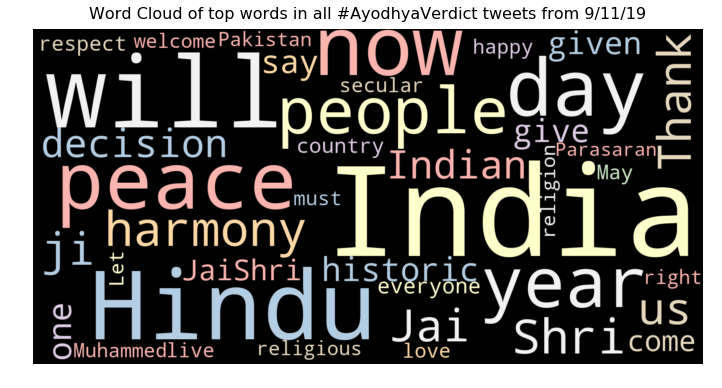

In [102]:
word_cloud(cleaned_tweets_all, "Word Cloud of top words in all #AyodhyaVerdict tweets from 9/11/19") 

In [103]:
# Define a function to create a wordcloud of top words and word pairs
def word_cloud(wd_list, title):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='Pastel1',
        max_words=40, max_font_size = 300).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.title(title, size = 16, pad = 10)
    plt.imshow(wordcloud, interpolation="bilinear");

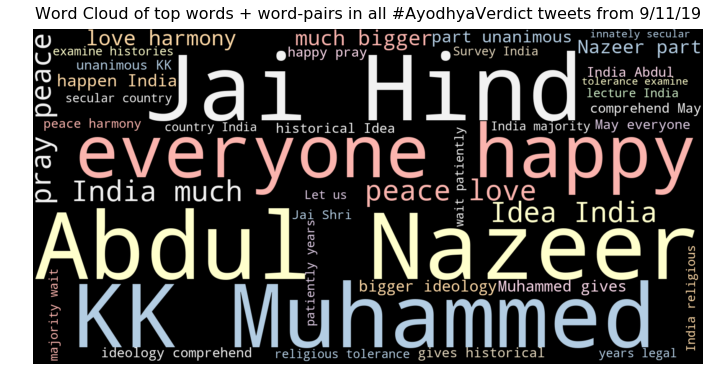

In [104]:
word_cloud(cleaned_tweets_all, "Word Cloud of top words + word-pairs in all #AyodhyaVerdict tweets from 9/11/19") 

In [105]:
# Create datasets of top English and Hindi tweets
most_rt_eng = tweets_original_eng.nlargest(5, "retweet_count")
most_fav_eng = tweets_original_eng.nlargest(5, "favorite_count")
top_eng = pd.concat([most_rt_eng, most_fav_eng]).drop_duplicates().reset_index(drop=True)

most_rt_hi = tweets_original_hi.nlargest(5, "retweet_count")
most_fav_hi = tweets_original_hi.nlargest(5, "favorite_count")
top_hi = pd.concat([most_rt_hi, most_fav_hi]).drop_duplicates().reset_index(drop=True)

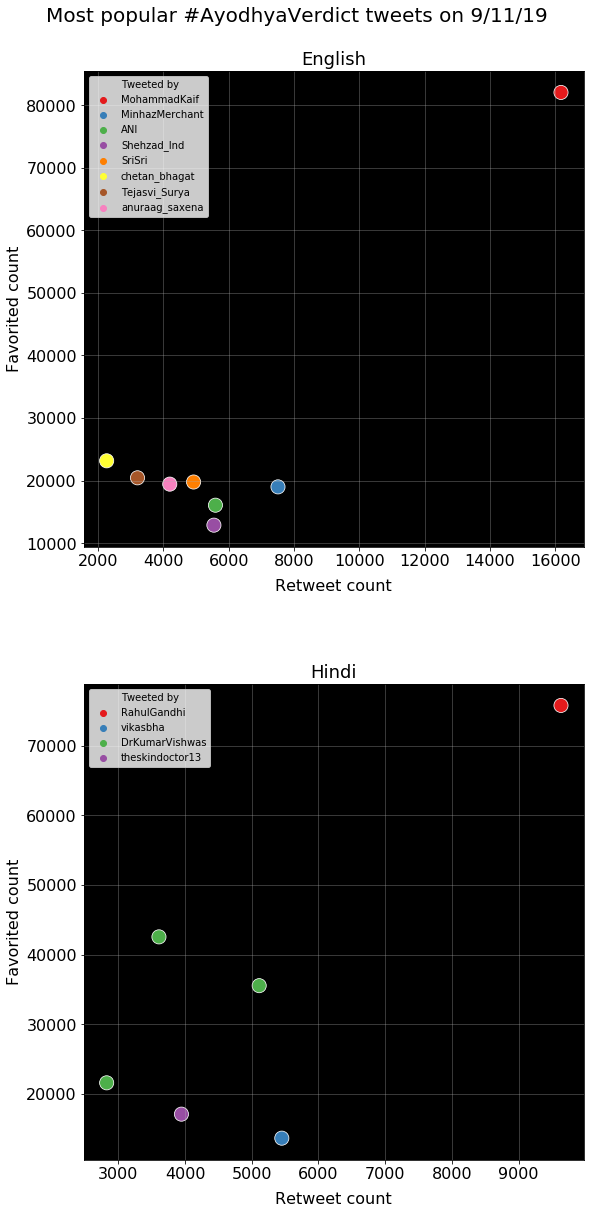

In [106]:
# Plot and compare top English and Hindi tweets 
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 18))
fig.suptitle("Most popular #AyodhyaVerdict tweets on 9/11/19", fontsize = 20)
a = sns.scatterplot(x='retweet_count',
    y='favorite_count',
    data=top_eng,    
    hue='screen_name', palette = "Set1", s = 200, ax = ax[0])
a.axes.set_title("English", fontsize = 18)
a.tick_params(labelsize = 16)
a.set_ylabel("Favorited count", fontsize = 16)
a.set_xlabel("Retweet count", fontsize = 16, labelpad = 10)
a.axes.legend(fontsize = 16)
a.axes.legend().texts[0].set_text("Tweeted by")
a.set_facecolor('xkcd:black')
a.grid(alpha = 0.4)
b = sns.scatterplot(x='retweet_count',
    y='favorite_count',
    data=top_hi,    
    hue='screen_name', palette = "Set1", s = 200, ax = ax[1])
b.axes.set_title("Hindi", fontsize = 18)
b.tick_params(labelsize = 16)
b.set_ylabel("Favorited count", fontsize = 16)
b.set_xlabel("Retweet count", fontsize = 16, labelpad = 10)
b.axes.legend(fontsize = 16)
b.axes.legend().texts[0].set_text("Tweeted by")
b.set_facecolor('xkcd:black')
b.grid(alpha = 0.4)
fig.tight_layout(pad = 7)
fig.show()


In [107]:
# Define a function to return emojis with their frequencies from the tweets
def emoji_counter(data):
    text = " ".join(data)
    emoji = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
    emojis = regexp_tokenize(text, emoji)
    emoji_string = "".join(emojis)
    char_with_modifier = re.compile(r'(.[\U0001f3fb-\U0001f3ff]?)')
    x = Counter(char_with_modifier.findall(emoji_string))
    return x.most_common()

In [108]:
emojis = emoji_counter(tweets["text"])
emojis

[("'", 103992),
 ('🙏', 101246),
 ('🚩', 40738),
 ('|', 23962),
 ('😂', 22327),
 ('❤', 18532),
 ('😢', 12382),
 ('😭', 10137),
 ('😍', 8304),
 ('🙏🏻', 7936),
 ('👍', 5307),
 ('😊', 4276),
 ('💐', 2901),
 ('👇', 2818),
 ('🔥', 2344),
 ('🌹', 2118),
 ('😎', 2114),
 ('🕉', 2042),
 ('😇', 2019),
 ('👏', 1992),
 ('✌', 1756),
 ('😁', 1588),
 ('😥', 1391),
 ('🙏🏼', 1343),
 ('💪', 1287),
 ('♥', 1258),
 ('🙌', 1229),
 ('☺', 1199),
 ('⛳', 1021),
 ('😜', 872),
 ('✅', 833),
 ('💥', 828),
 ('🏃', 827),
 ('😹', 822),
 ('👌', 797),
 ('➡', 796),
 ('🌷', 790),
 ('😀', 782),
 ('🙄', 776),
 ('👍🏻', 749),
 ('🏹', 733),
 ('💕', 728),
 ('💓', 678),
 ('✔', 660),
 ('❣', 638),
 ('🙂', 633),
 ('♂', 625),
 ('👉', 620),
 ('🙏🏽', 607),
 ('😠', 522),
 ('🌟', 516),
 ('✌🏻', 515),
 ('✨', 513),
 ('☪', 508),
 ('😡', 504),
 ('🎉', 501),
 ('😆', 486),
 ('😄', 486),
 ('😉', 471),
 ('☹', 470),
 ('\U0001f6d5', 443),
 ('👏🏻', 441),
 ('😷', 428),
 ('😘', 425),
 ('😏', 413),
 ('💖', 389),
 ('🔸', 385),
 ('🚶', 338),
 ('💃', 335),
 ('🌸', 326),
 ('😝', 321),
 ('😃', 317),
 ('☝', 311

In [109]:
# Convert the Counter object into a dictionary and then dataframe
emoji_dict = dict(emojis)
key = emoji_dict.keys()
df = pd.DataFrame(emojis,index=key)
df

,0,1
',',103992
🙏,🙏,101246
🚩,🚩,40738
|,|,23962
😂,😂,22327
❤,❤,18532
😢,😢,12382
😭,😭,10137
😍,😍,8304
🙏🏻,🙏🏻,7936


In [110]:
# Clean up the emojis dataframe
df.reset_index(inplace = True, drop = True)
# Merge identical emojis
df[1][1] = (df[1][1] + df[1][9])
# Drop non-emoji characters
df.drop(index = [0, 3, 9], inplace = True)
df.reset_index(drop = True, inplace = True)
# Separate the top 20 emojis 
df_20 = df[:20]

In [112]:
# Save emojis and their frequencies for plotting
em = df_20[0]
freq = df_20[1] 

In [114]:
print('Default backend: ' + matplotlib.get_backend()) 
matplotlib.use("module://mplcairo.macosx")
print('Backend is now ' + matplotlib.get_backend())

Default backend: module://mplcairo.macosx
Backend is now module://mplcairo.macosx


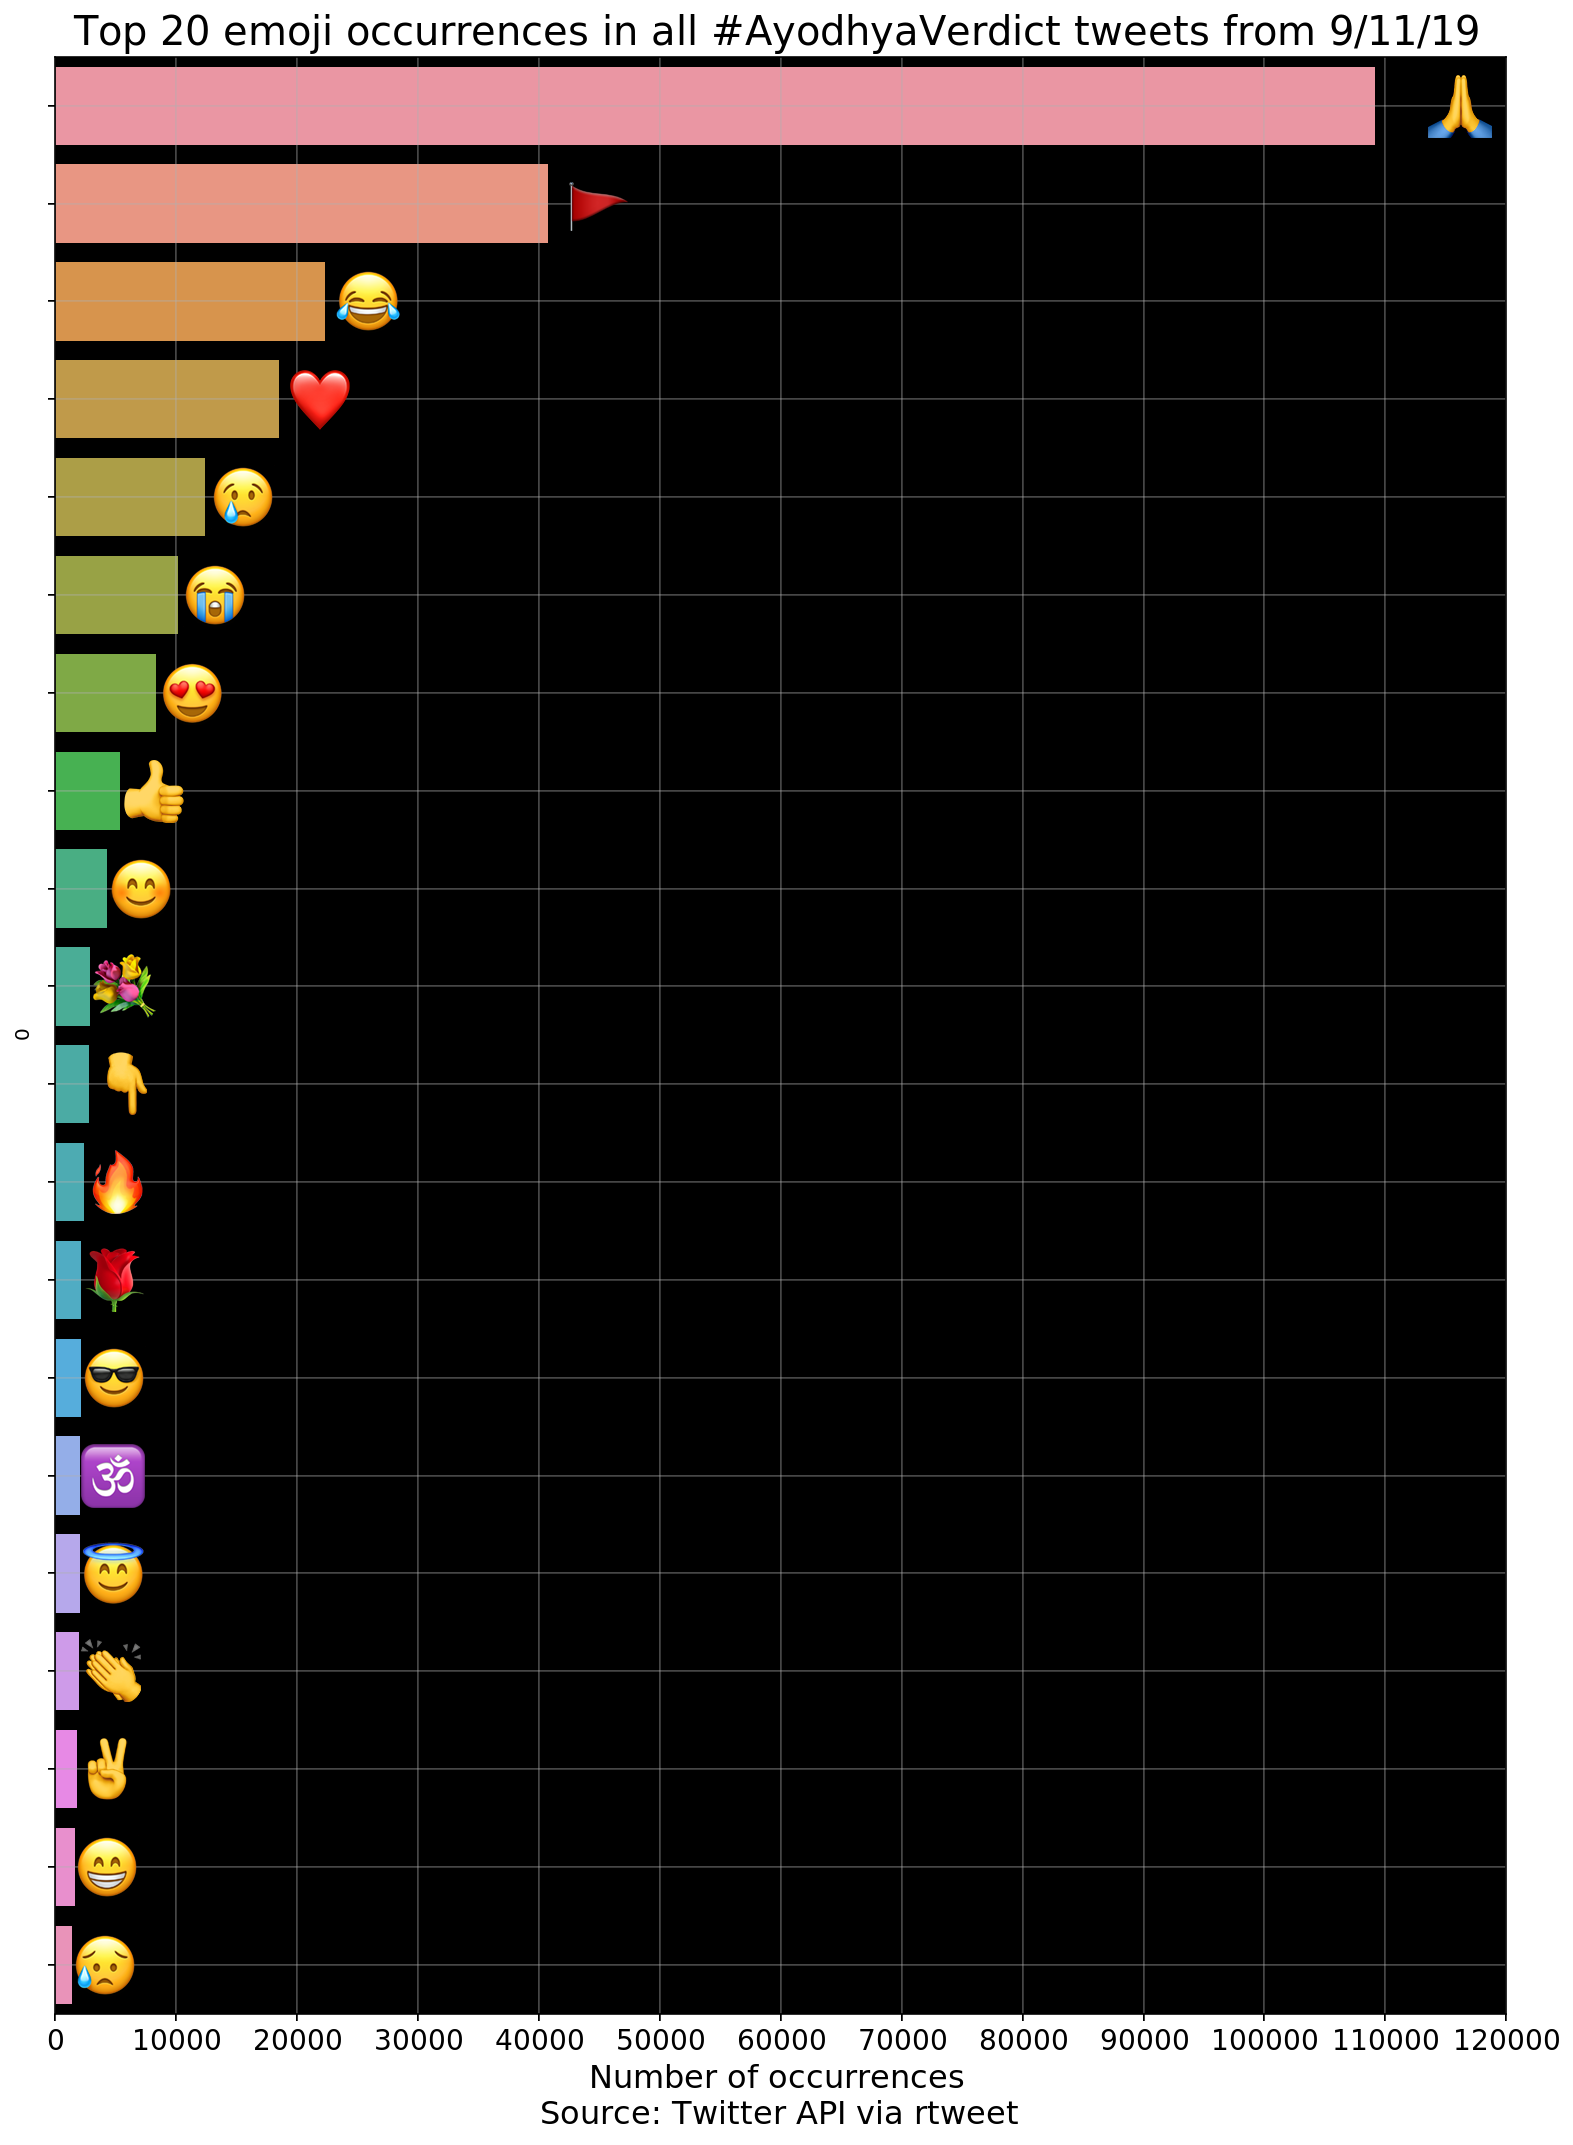

In [115]:
# Load Apple Color Emoji font 
prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')

plt.figure(figsize = (13, 18))
a = sns.barplot(y = em, x = freq, orient = "h")

patches = a.patches
for rect1, e in zip(patches, em):
    width = rect1.get_width()
    plt.annotate(
        e,
        (1.04*width, rect1.get_y()+0.5*rect1.get_height()),
        #ha="center",
        va="center",
        fontsize=32,
        fontproperties=prop)
    
a.axes.set_title("Top 20 emoji occurrences in all #AyodhyaVerdict tweets from 9/11/19", fontsize = 20)

a.tick_params(labelsize = 14)
a.set_xlabel("Number of occurrences \nSource: Twitter API via rtweet", fontsize = 16)
a.set_facecolor('xkcd:black')
a.axes.set_yticklabels("")
a.grid(alpha = 0.4)
plt.xticks(np.arange(0, 130000, 10000))
plt.show()
